<div class="usecase-title">Pedestrian Accidents and Bus Stops</div>

<div class="usecase-authors"><b>Author: </b>Alison Collins</div>


<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data Preprocessing, Data Analysis, Statisical Analysis</div>
</div>

<div class="usecase-section-header">Scenario</div>

1. As a city planner, I want to identify which bus stops are the safest and most dangerous for pedestrians to assist with future planning.

2. As an emergency services worker, I want to know if accident locations can be predicted by bus stop to bus stop proximity.

3. As a pedestrian, I want to know which bus stop locations are safer for my use.


<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Import Melbourne City data using API v2.1 GET request with /exports extension
- Import GeoJSON files from websites using GET requests
- Import libraries, check for missing /null values
- Resampling dataframes with groupby function
- Dataframe merges and concatenation
- Data visualisation with matplotlib and plotly
- Convert between Geodataframes and dataframes
- Mapping with folium
- Distance calculation with Haversine
- Logarithmic transformations of data
- Null hypothesis testing

<div class="usecase-section-header">Background</div>

The Transport Accident Commision of Victoria <a href="#fn-1">[1]</a> reports alarming statistics about pedestrian safety. In the last 5 yeasr, 175 pedestrians have been killed on victorian roads, with 4 in 10 killed on roads with speeds 60km/h or less and 70% of those numbers in Metro Melbrourne. These statistics highlight the need of an investigation into the road safety of pedestrians in Metro Melbourne.</br>

Bus stops as locations adjacent to accidents are of particular interest. Bus stops let passengers onto and off buses, meaning that these are areas of high pedestrian numbers. In addition, audits by Victoria Walks <a href="#fn-2">[2]</a> has found that most bus stops (95%) do not have a crossing within 20m. This highlights the need for an investigation into pedestrian safety around bus stop locations. The distance between bus stops and the distance from accidents to bus stops will be of interest, to evaluate if there is a correlation between these.


<div class="usecase-section-header">Relevant Datasets</div>

[Bus Stops](https://data.melbourne.vic.gov.au/explore/dataset/bus-stops/information/)

- This dataset shows the Melbourne City Bus Stop locations. For this investigation, the most important  columns are those that hold the geographical position of the bus stop. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Victoria Road Crash Data](https://discover.data.vic.gov.au/dataset/victoria-road-crash-data)
- This dataset is a record of the road crashes and injuries across Victoria. The GeoJSON file holds detailed information about every crash reported by Victoria Police and Hospital injury information. Relevant attriibutes to this investigation are road user type (pedestrian), severity and location. This dataset is imported from Data VIC, using a GET request to obtain a GeoJSON datafile from a url address.

### REQUIRED MODULES

In [272]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

import requests
import pandas as pd
import numpy as np

from io import StringIO

import matplotlib.pyplot as plt
import plotly.express as px

import geopandas as gpd
import folium

import statistics
from scipy.stats import pearsonr

### IMPORT DATASETS

In [273]:
#Function to collect data using API v 2.1
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key #use if use datasets API_key permissions
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey  #use if datasets require API_key permissions
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [274]:
# IMPORT BUS STOPS DATASET
# Set dataset_id to query for the API call dataset name
dataset_id = 'bus-stops'
# Save dataset to df varaible
bus_data = collect_data(dataset_id)
# Check number of records in df
print(f'The dataset contains {len(bus_data)} records.')
# View df
bus_data.head(3)

The dataset contains 309 records.


,geo_point_2d,geo_shape,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,asset_subt,model_desc,mcc_id,roadseg_id,descriptio,model_no
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.819824,357,Signage,Sign - Public Transport,355,1235255,570648,NaN,Sign - Public Transport 1 Panel,1235255,21673,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.561304,83,Signage,Sign - Public Transport,600,1231226,548056,NaN,Sign - Public Transport 1 Panel,1231226,20184,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.177187,207,Signage,Sign - Public Transport,640,1237092,543382,NaN,Sign - Public Transport 1 Panel,1237092,20186,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16


In [275]:
# URL to the GeoJSON file
url = 'https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Road_Safety/VICTORIAN_ROAD_CRASH_DATA.geojson'

# Set the User-Agent to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# Make the HTTP request
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Load GeoJSON data into a pandas DataFrame
    data = response.json()
    features = data['features']
    properties_data = [feature['properties'] for feature in features]
    crash_data = pd.DataFrame(properties_data)
    print(f'The dataset contains {len(crash_data)} records.')
else:
    print(f'Failed to retrieve data: {response.status_code}')

# View df
crash_data.head(3)

The dataset contains 168360 records.


,ACCIDENT_NO,ACCIDENT_DATE,ACCIDENT_TIME,ACCIDENT_TYPE,DAY_OF_WEEK,DCA_CODE,LIGHT_CONDITION,POLICE_ATTEND,ROAD_GEOMETRY,SEVERITY,SPEED_ZONE,RUN_OFFROAD,NODE_ID,NODE_TYPE,LGA_NAME,LATITUDE,LONGITUDE,VICGRID_X,VICGRID_Y,TOTAL_PERSONS,INJ_OR_FATAL,FATALITY,SERIOUSINJURY,OTHERINJURY,NONINJURED,MALES,FEMALES,BICYCLIST,PASSENGER,DRIVER,PEDESTRIAN,PILLION,MOTORCYCLIST,UNKNOWN,PED_CYCLIST_5_12,PED_CYCLIST_13_18,OLD_PED_65_AND_OVER,OLD_DRIVER_75_AND_OVER,YOUNG_DRIVER_18_25,NO_OF_VEHICLES,HEAVYVEHICLE,PASSENGERVEHICLE,MOTORCYCLE,PT_VEHICLE,DEG_URBAN_NAME,SRNS,RMA,DIVIDED,STAT_DIV_NAME
0,T20120000009,20120101,022500,Collision with a fixed object,Sunday,LEFT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,Dark No street lights,Yes,Not at intersection,Other injury accident,100 km/hr,Yes,249102,Non-Intersection,BAW BAW,-38.234957,145.726709,2563628.962,2362700.434,2,2,0,0,2,0,2,0,0,1,1,0,0,0,0,0,0,0,0,1,1.0,0.0,1.0,0.0,0.0,RURAL_VICTORIA,C,Arterial Other,Undivided,Country
1,T20120000012,20120101,020000,Collision with vehicle,Sunday,CROSS TRAFFIC(INTERSECTIONS ONLY),Dark Street lights on,Yes,Cross intersection,Serious injury accident,80 km/hr,No,41780,Non-Intersection,MONASH,-37.903541,145.161404,2514194.683,2399718.586,3,1,0,1,0,2,2,0,0,1,2,0,0,0,0,0,0,0,0,0,2.0,0.0,2.0,0.0,0.0,MELB_URBAN,None,None,None,Metro
2,T20120000013,20120101,033500,Collision with vehicle,Sunday,VEHICLE COLLIDES WITH VEHICLE PARKED ON LEFT O...,Dark Street lights on,Yes,T intersection,Serious injury accident,60 km/hr,No,69811,Intersection,KINGSTON,-37.935940,145.098848,2508689.410,2396130.003,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2.0,0.0,2.0,0.0,0.0,MELB_URBAN,None,Arterial Other,Undivided,Metro


### DATASET PREPROCESSING

#### Bus Stop Data

Check columns and delete those not needed for analysis. Check for null values and delete any rows with missing values. Check data types in columns.

In [276]:
# Check the names of the columns
column_names = bus_data.columns.tolist()
print("\033[1mColumn names:\033[0m")
print(column_names)

Column names:
['geo_point_2d', 'geo_shape', 'prop_id', 'addresspt1', 'addressp_1', 'asset_clas', 'asset_type', 'objectid', 'str_id', 'addresspt', 'asset_subt', 'model_desc', 'mcc_id', 'roadseg_id', 'descriptio', 'model_no']


In [277]:
# Drop the unnesccessary columns, save back to bus variable
bus = bus_data[["geo_shape","addresspt1","asset_type","str_id"]]

# Rename str_id to stop_name
bus.rename(columns={'str_id': 'stop_name'}, inplace=True)

# Extract latitude and longitude from geo_shape
bus['coordinates'] = bus['geo_shape'].apply(lambda x: eval(x)['coordinates'])
bus[['longitude', 'latitude']] = pd.DataFrame(bus['coordinates'].tolist(), index=bus.index)
bus.head(2)

,geo_shape,addresspt1,asset_type,stop_name,coordinates,longitude,latitude
0,"{""coordinates"": [144.93239283833262, -37.80384...",76.819824,Sign - Public Transport,1235255,"[144.93239283833262, -37.80384165792465]",144.932393,-37.803842
1,"{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,1231226,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487


In [278]:
# Check for null values
print("\033[1mNaN Value in Bus-stop Data:\033[0m")
print(bus.isna().sum())

NaN Value in Bus-stop Data:
geo_shape      0
addresspt1     0
asset_type     0
stop_name      0
coordinates    0
longitude      0
latitude       0
dtype: int64


In [279]:
# Check data types
print("\033[1m\nData Types in Bus-stop Data:\033[0m")
print(bus.dtypes)


Data Types in Bus-stop Data:
geo_shape       object
addresspt1     float64
asset_type      object
stop_name        int64
coordinates     object
longitude      float64
latitude       float64
dtype: object


In [280]:
# Select only rows within specified geographical area
bus_int = bus[(bus['latitude'] > -37.82106) & (bus['latitude'] <= -37.80003)]
bus_city = bus_int[(bus_int['longitude'] > 144.9501) & (bus_int['longitude'] <= 144.96103)]

# Check number of records in df
print(f'The dataset contains {len(bus_city)} records.')
# View df
bus_city.head(3)

The dataset contains 55 records.


,geo_shape,addresspt1,asset_type,stop_name,coordinates,longitude,latitude
1,"{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,1231226,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487
2,"{""coordinates"": [144.95728334230756, -37.81353...",42.177187,Sign - Public Transport,1237092,"[144.95728334230756, -37.81353897396532]",144.957283,-37.813539
9,"{""coordinates"": [144.95370614040704, -37.81249...",16.143764,Sign - Public Transport,1253565,"[144.95370614040704, -37.812490976626215]",144.953706,-37.812491


#### Crash Data

Check columns and delete those not needed for analysis. Select only the data where pedestrians were involved in accidents. Check for null vlaues and delete any rows with missing values. Check data types in columns.

In [281]:
# Check the names of the columns
column_names = crash_data.columns.tolist()
print(column_names)

['ACCIDENT_NO', 'ACCIDENT_DATE', 'ACCIDENT_TIME', 'ACCIDENT_TYPE', 'DAY_OF_WEEK', 'DCA_CODE', 'LIGHT_CONDITION', 'POLICE_ATTEND', 'ROAD_GEOMETRY', 'SEVERITY', 'SPEED_ZONE', 'RUN_OFFROAD', 'NODE_ID', 'NODE_TYPE', 'LGA_NAME', 'LATITUDE', 'LONGITUDE', 'VICGRID_X', 'VICGRID_Y', 'TOTAL_PERSONS', 'INJ_OR_FATAL', 'FATALITY', 'SERIOUSINJURY', 'OTHERINJURY', 'NONINJURED', 'MALES', 'FEMALES', 'BICYCLIST', 'PASSENGER', 'DRIVER', 'PEDESTRIAN', 'PILLION', 'MOTORCYCLIST', 'UNKNOWN', 'PED_CYCLIST_5_12', 'PED_CYCLIST_13_18', 'OLD_PED_65_AND_OVER', 'OLD_DRIVER_75_AND_OVER', 'YOUNG_DRIVER_18_25', 'NO_OF_VEHICLES', 'HEAVYVEHICLE', 'PASSENGERVEHICLE', 'MOTORCYCLE', 'PT_VEHICLE', 'DEG_URBAN_NAME', 'SRNS', 'RMA', 'DIVIDED', 'STAT_DIV_NAME']


In [282]:
# Select only the rows where pedestrians are involved
crash = crash_data.drop(crash_data[crash_data['PEDESTRIAN'] == 0].index)

# Drop the unnesccessary columns, save back to bus variable
crash = crash[["ACCIDENT_NO","ACCIDENT_DATE","ACCIDENT_TIME","PEDESTRIAN","SEVERITY","LATITUDE","LONGITUDE"]]

# Rename columns to lowercase
crash.columns = [col.lower() for col in crash.columns]

crash.head(2)

,accident_no,accident_date,accident_time,pedestrian,severity,latitude,longitude
6,T20120000032,20120101,005500,1,Other injury accident,-37.841733,144.953222
9,T20120000046,20120101,162500,1,Other injury accident,-38.367171,144.877550


In [283]:
# Check for null values in crash data
print("\033[1m\nNaN Values in Crash Data:\033[0m")
print(crash.isna().sum())


NaN Values in Crash Data:
accident_no      0
accident_date    0
accident_time    0
pedestrian       0
severity         0
latitude         0
longitude        0
dtype: int64


In [284]:
# Convert the date and time columns to strings
crash['accident_date'] = crash['accident_date'].astype(str)
crash['accident_time'] = crash['accident_time'].astype(str)

# Combine accident date and time to make a timestamp column
crash['timestamp'] = pd.to_datetime(crash['accident_date'] + ' ' + crash['accident_time'], format='mixed')

crash.head(2)

,accident_no,accident_date,accident_time,pedestrian,severity,latitude,longitude,timestamp
6,T20120000032,20120101,005500,1,Other injury accident,-37.841733,144.953222,2012-01-01 00:55:00
9,T20120000046,20120101,162500,1,Other injury accident,-38.367171,144.877550,2012-01-01 16:25:00


In [285]:
unique_values = crash['severity'].unique()
print(unique_values)

['Other injury accident' 'Serious injury accident' 'Fatal accident']


In [286]:
unique_values = crash['pedestrian'].unique()
print(unique_values)

[1 2 3 5 4 6 7 9]


In [287]:
# Check data types
print("\033[1m\nData Types in Crash Data:\033[0m")
print(crash.dtypes)


Data Types in Crash Data:
accident_no              object
accident_date            object
accident_time            object
pedestrian                int64
severity                 object
latitude                float64
longitude               float64
timestamp        datetime64[ns]
dtype: object


In [288]:
# Select only rows within specified gerograhical area
crash_int = crash[(crash['latitude'] > -37.82106) & (crash['latitude'] <= -37.80003)]
crash_city = crash_int[(crash_int['longitude'] > 144.9501) & (crash_int['longitude'] <= 144.96103)]

# Check number of records in df
print(f'The dataset contains {len(crash_city)} records.')
# View df
bus_city.head(3)

The dataset contains 349 records.


,geo_shape,addresspt1,asset_type,stop_name,coordinates,longitude,latitude
1,"{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,1231226,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487
2,"{""coordinates"": [144.95728334230756, -37.81353...",42.177187,Sign - Public Transport,1237092,"[144.95728334230756, -37.81353897396532]",144.957283,-37.813539
9,"{""coordinates"": [144.95370614040704, -37.81249...",16.143764,Sign - Public Transport,1253565,"[144.95370614040704, -37.812490976626215]",144.953706,-37.812491


### EXPLORATORY DATA ANALYSIS

#### Crash Data

Count the number of accidents occurring on each day and display in a temporal graph.

In [289]:
# Group the data by the date and count the rows for each date, make new dataframe
date_counts = crash_city.groupby(crash['timestamp'].dt.date).size().reset_index(name='count')

# Rename the columns for clarity
date_counts.columns = ['date', 'count']

# Check number of records in df
print(f'The dataset contains {len(date_counts)} records.')
# Display df
date_counts.head(3)

The dataset contains 335 records.


,date,count
0,2012-01-05,1
1,2012-01-08,1
2,2012-01-10,1


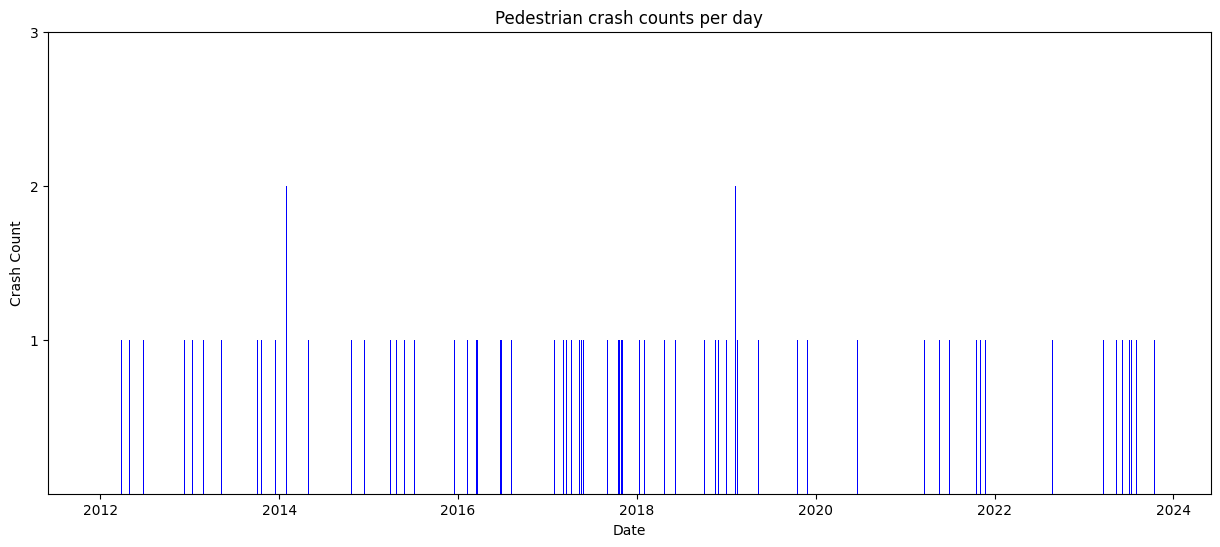

In [290]:
# Plot temporal patterns in pedestrian counts at alll locations
plt.rcParams['figure.figsize'] = [15, 6]
plt.bar(date_counts['date'], date_counts['count'], color='blue')
plt.title('Pedestrian crash counts per day')
plt.xlabel('Date')
plt.ylabel('Crash Count')
# Set custom y-axis values
y_ticks = [1,2,3]
plt.yticks(ticks=y_ticks)
plt.show()

Temporal patterns in crash data shows that the dataset is over 12 years. The maximum number of crashes is 2, with many days at 0 recorded crashes. It would be useful to know which type of accidents are the most common.

In [291]:
# Plot treemap of bus stop and non bus stop counts
fig = px.treemap(crash_city, path=['severity'], width=800, height=400, title="Total accidents by classification of type", color="severity", 
    color_discrete_map={
        "Other injury accident": "lightyellow",
        "Serious injury accident": "orange",
        "Fatal accident": "red"
    })
fig.show()

The treemap shows that the most frequent category of accident is other, where patients did not require hospitalisation <a href="#fn-3">[3]</a>. Serious injury accidents where patients required hospitalisation are next, with 141 pedestrians impacted by these. In the 12 year period surveyed, there were 7 fatalities in accidents involving pedestrians.

A view of both the of locations of accidents and bus stop locations at the same time allows investgation of if there is overlap between these datasets.

In [292]:
# Create GeoDataFrames
gdf_bus = gpd.GeoDataFrame(bus_city, geometry=gpd.points_from_xy(bus_city['latitude'], bus_city['longitude']))

gdf_crash = gpd.GeoDataFrame(crash_city, geometry=gpd.points_from_xy(crash_city['latitude'], crash_city['longitude']))

In [293]:
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.815, 144.96],zoom_start = 14,tiles="Cartodb Positron")

# Add a circle marker for each accident location  
for i in range(0,len(gdf_crash)):
    folium.Circle(
        location=[gdf_crash.iloc[i]['latitude'], gdf_crash.iloc[i]['longitude']],
        radius=20,
        color='red',
        fill_color='red'
   ).add_to(m)
    
# Add a circle marker for each bus stop location
for i in range(0,len(gdf_bus)):
    folium.Circle(
        location=[gdf_bus.iloc[i]['latitude'], gdf_bus.iloc[i]['longitude']],
        radius=20,
        color='black',
        fill_color='black'
   ).add_to(m)

# Title for map
m.get_root().html.add_child(folium.Element("<h3 align='center'>Locations of Pedestrian Accidents Bus Stop Location</h3>"))

m

This map shows the locations of bus stops and accidents. It can be seen that there is some overlap between bus stop locations and where accidents with pedestrians occurred. Breaking down the map by accident severity can allow for stakeholders to identify locations where accidents caused more harm.

In [294]:
# Types of accidents
other = crash_city.loc[crash_city['severity'] == 'Other injury accident']
severe = crash_city.loc[crash_city['severity'] == 'Serious injury accident']
fatal = crash_city.loc[crash_city['severity'] == 'Fatal accident']

# Create GeoDataFrames from types of accidents
gdf_other = gpd.GeoDataFrame(other, geometry=gpd.points_from_xy(other['latitude'], other['longitude']))
gdf_severe = gpd.GeoDataFrame(severe, geometry=gpd.points_from_xy(severe['latitude'], severe['longitude']))
gdf_fatal = gpd.GeoDataFrame(fatal, geometry=gpd.points_from_xy(fatal['latitude'], fatal['longitude']))

In [295]:
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.815, 144.96],zoom_start = 14,tiles="Cartodb Positron")

# Add pedestrian numbers at locations without bus stops
for i in range(0,len(gdf_other)):
   folium.Circle(
      location=[gdf_other.iloc[i]['latitude'], gdf_other.iloc[i]['longitude']],
      radius=30,
      color='yellow',
      fill_color='yellow'
   ).add_to(m)
   
# Add pedestrian numbers at locations with bus stops
for i in range(0,len(gdf_severe)):
   folium.Circle(
      location=[gdf_severe.iloc[i]['latitude'], gdf_severe.iloc[i]['longitude']],
      radius=30,
      color='orange',
      fill_color='orange'
   ).add_to(m)
   
# Add pedestrian numbers at locations with bus stops
for i in range(0,len(gdf_fatal)):
   folium.Circle(
      location=[gdf_fatal.iloc[i]['latitude'], gdf_fatal.iloc[i]['longitude']],
      radius=30,
      color='red',
      fill_color='red'
   ).add_to(m)

# Add a circle marker for each bus stop location
for i in range(0,len(gdf_bus)):
    folium.Circle(
        location=[gdf_bus.iloc[i]['latitude'], gdf_bus.iloc[i]['longitude']],
        radius=20,
        color='black',
        fill_color='black'
   ).add_to(m)
    
# Title for map
m.get_root().html.add_child(folium.Element("<h3 align='center'>Locations of accidents by type</h3>"))

# Show the map
m

Geomapping of accident by types shows that all fatalities excepting one occurred close to bus stop locations. Streets running north to south across the city appear to have more serious accidents occuring along them than streets running east to west.

### ANALYSIS OF DISTANCE

Measurements of distance between bus stops and from crash locations to closest bus stop will be calculated using the Haversine formula. This formula calculates the shortest distance between two points on the sphere of the Earth using latitude and longitude co-ordinates <a href="#fn-4">[4]</a>. Haversine distance was chosen for its ease of calculation from the information availible in the datasets used here as well as its accuracy.

In [296]:
# Function to calculate haversine distance between two pairs of geographhical locations
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  
    # Earth's radius in kilometers
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance


#### Between Bus Stops

In [297]:
# Calculate distances between all pairs of bus stops
for i, row1 in bus_city.iterrows():
    min_distance = float("inf")
    next_closest_stop = None
    for j, row2 in bus_city.iterrows():
        if i != j:
            dist = haversine(row1["latitude"], row1["longitude"], row2["latitude"], row2["longitude"])
            if dist < min_distance:
                min_distance = dist
                next_closest_stop = row2["stop_name"]
    bus_city.loc[i, "next_closest_stop"] = next_closest_stop
    bus_city.loc[i, "distance_to_stop"] = min_distance

# Convert next closest stop to int
bus_city['next_closest_stop'] = bus_city['next_closest_stop'].astype(int)
bus_city['distance_to_stop']=bus_city['distance_to_stop'].replace(0, 0.000001)

# Show df
bus_city.head(2)

,geo_shape,addresspt1,asset_type,stop_name,coordinates,longitude,latitude,next_closest_stop,distance_to_stop
1,"{""coordinates"": [144.9581794249902, -37.815486...",21.561304,Sign - Public Transport,1231226,"[144.9581794249902, -37.81548699581418]",144.958179,-37.815487,1236808,0.035341
2,"{""coordinates"": [144.95728334230756, -37.81353...",42.177187,Sign - Public Transport,1237092,"[144.95728334230756, -37.81353897396532]",144.957283,-37.813539,1231223,0.033488


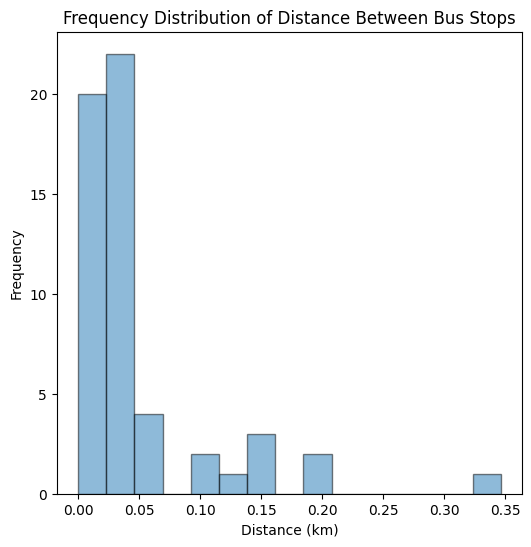

In [299]:
# Set plot size
plt.rcParams['figure.figsize'] = [6, 6]
# Create a  histogram
bus_city['distance_to_stop'].plot.hist(bins=15, edgecolor='black', alpha=0.5)
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Distance Between Bus Stops')
plt.show()

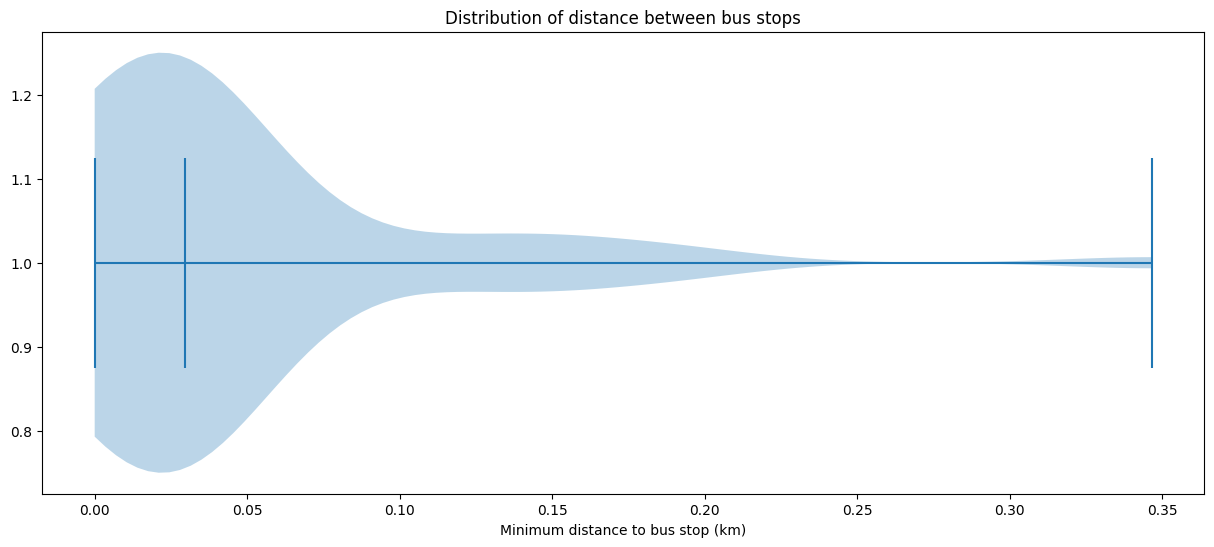

In [300]:
# Set plot size
plt.rcParams['figure.figsize'] = [15, 6]
# Call violin plot on distance from bus stop to bus stop
plt.violinplot(bus_city['distance_to_stop'], showmedians=True, vert=False)
# Set plot labels and title
plt.title("Distribution of distance between bus stops")
plt.xlabel('Minimum distance to bus stop (km)')
plt.show()

The distance between bus stops in the histogram shows that in Central Melbourne, most bus stops are less than 500m apart. The violin plot echos this distribution, also stating that the median distance is 300m between bus stops. This is as expected as on the map there are many bus stops shown in the area between Collins street, La Trobe street, William street and Spencer street.

#### From Crash Locations to Bus Stops

In [301]:
# Apply haversine function
# Initiate new column in crash city data
crash_city['min_dist'] = np.inf

# Loop calculating closest distance to bus stop from accident location
for _, row1 in bus_city.iterrows():
    for _, row2 in crash_city.iterrows():
        dist = haversine(row1['longitude'], row1['latitude'], row2['longitude'], row2['latitude'])
        if dist < crash_city.loc[_, 'min_dist']:
            crash_city.loc[_, 'min_dist'] = dist
            crash_city.loc[_, 'min_bus_stop'] = row1['stop_name']

crash_city.head(2)

,accident_no,accident_date,accident_time,pedestrian,severity,latitude,longitude,timestamp,min_dist,min_bus_stop
92,T20120000296,20120105,153000,1,Serious injury accident,-37.80789,144.957949,2012-01-05 15:30:00,0.206581,1238699.0
171,T20120000506,20120108,131500,1,Other injury accident,-37.81939,144.957106,2012-01-08 13:15:00,0.121817,1268402.0


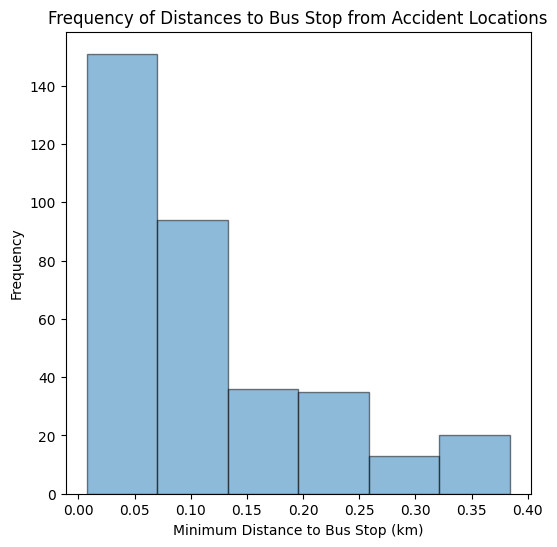

In [302]:
# Set plot size
plt.rcParams['figure.figsize'] = [6, 6]
# Create a histogram
crash_city['min_dist'].plot(kind='hist', bins=6,edgecolor='black', alpha=0.5)
plt.xlabel('Minimum Distance to Bus Stop (km)')
plt.ylabel('Frequency')
plt.title('Frequency of Distances to Bus Stop from Accident Locations')
plt.show()

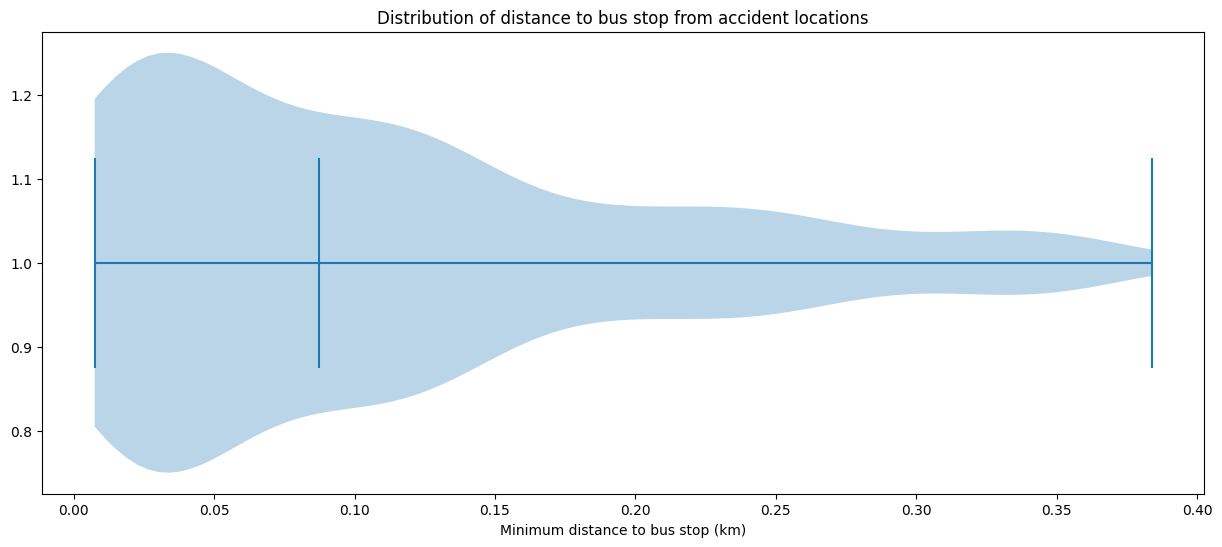

In [303]:
# Set plot size
plt.rcParams['figure.figsize'] = [15, 6]
# Call violin plot on distance from crash location to bus stop
plt.violinplot(crash_city['min_dist'], showmedians=True, vert=False)
# Set plot labels and title
plt.title("Distribution of distance to bus stop from accident locations")
plt.xlabel('Minimum distance to bus stop (km)')
plt.show()

The distance between bus stops and accident locations in the histogram shows that in Central Melbourne, most accidents occur less than 1km from a bus stop. The violin plot echos this distribution, also stating that the median distance is 700m from bus stops.

### ANALYSIS OF MOST DANGEROUS BUS STOPS

Distance of accidents to bus stops will be used to determine the locations of the most dangerous bus stops. These will be graphed and mapped.

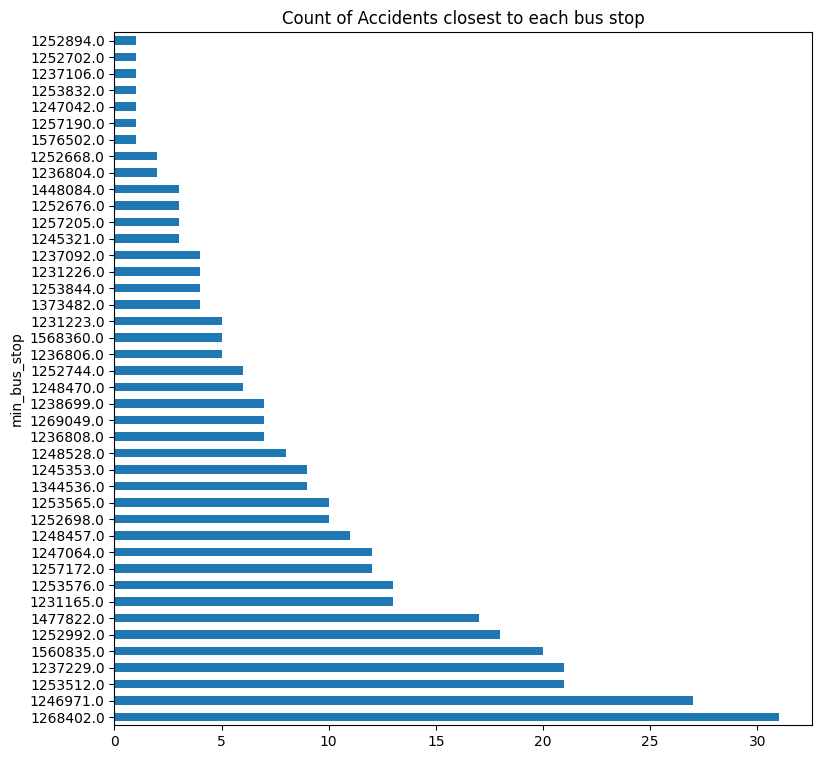

In [304]:
plt.rcParams['figure.figsize'] = [9, 9]
# Create a bar plot
crash_city['min_bus_stop'].value_counts().plot(kind='barh',title="Count of Accidents closest to each bus stop")
plt.show()

The most dangerous bus stop is location 1268402 with over 32 pedestrian accidents over the 12 year period, followed by 1246971 with 27 pedestrian accidents in the same time period. Seven bus stops had only one accident recorded in their vicinity in the 12 year survey period. It would be useful to visualise the locations of these bus stops.

In [305]:
# Create a dataframe of counts of pedestrian accidents nearest each bus stop location
stop_crash_counts = pd.DataFrame(crash_city['min_bus_stop'].value_counts())

# Add and index and rename columns for merging
stop_crash_counts = stop_crash_counts.reset_index()
stop_crash_counts.columns = ['stop_name', 'accidents']

# Merge with bus city to add locations
stop_crash_counts = stop_crash_counts.merge(bus_city, on='stop_name', how='left')
stop_crash_counts.head(2)

,stop_name,accidents,geo_shape,addresspt1,asset_type,coordinates,longitude,latitude,next_closest_stop,distance_to_stop
0,1268402.0,31,"{""coordinates"": [144.956839508202, -37.8183148...",35.877984,Sign - Public Transport,"[144.956839508202, -37.818314889062094]",144.956840,-37.818315,1247064,0.048216
1,1246971.0,27,"{""coordinates"": [144.95412220092587, -37.81888...",14.345030,Sign - Public Transport,"[144.95412220092587, -37.81888176511253]",144.954122,-37.818882,1246970,0.000001


In [306]:
# Create geodataframe from stop crash counts dataframe
gdf_stop_crash_counts= gpd.GeoDataFrame(stop_crash_counts, geometry=gpd.points_from_xy(stop_crash_counts.longitude, stop_crash_counts.latitude), crs="EPSG:4326")


# Create map object of water_gdf dataset, call explore method
m = gdf_stop_crash_counts.explore(
    column="accidents",  # make choropleth based on "count" column
    cmap = "YlOrRd",  # set colormap to yellow, orange, red,
    legend=True,  # show legend
    tooltip=False,  # hide tooltip
    marker_kwds=dict(radius=10, fill=True), # Make amrkers large size
    fill_opacity=0.1,
    popup=["accidents","stop_name"],  # show popup (on-click) of count and stop name
    legend_kwds=dict(colorbar=True),  #not use colorbar key
    name="Crash Counts",  # name of the layer in the map
)

# Use folium to add alternative tiles
folium.TileLayer(tiles="Cartodb Positron").add_to(m)  # convert map to soft colours
# Use folium to add layer control
folium.LayerControl().add_to(m)  

# Show map
m 

The map uses a chloropleth to indicate the most and least dangerous bus stops. Red has the highest number of pedestrian accidents while yellow has the least. By selecting a bus stop the stop name and number of accidents can be viewed. The most dangerous bus stops are at the coner of Collins street and Spencer street, and at the corenr of King street and Collins street.

### RELATIONSHIP BETWEEN DISTANCE MEASUREMENTS

To determine if there is a relationship between the distance between bus stops and the distance of accidents from bus stops, first the average distance of accidents from each bus stop needs to be calculated. This value will be used in calculations. For logarithmic scaling, any zero values must be replaces with a value close to zero.

In [308]:
# Group by 'stop' and calculate mean distance
per_stop_crash_dist = crash_city.groupby('min_bus_stop')['min_dist'].mean().reset_index()
per_stop_crash_dist['min_dist']=per_stop_crash_dist['min_dist'].replace(0, 0.000001)
per_stop_crash_dist.columns = ['stop_name', 'accident_distance']
per_stop_crash_dist.head(2)

,stop_name,accident_distance
0,1231165.0,0.095079
1,1231223.0,0.084336


In [309]:
# Join dataframe to have distance to stop and distance to accident in one dataframe
per_stop_avg_dist = per_stop_crash_dist.merge(bus_city, on='stop_name', how='left')
per_stop_avg_dist.head(2)


,stop_name,accident_distance,geo_shape,addresspt1,asset_type,coordinates,longitude,latitude,next_closest_stop,distance_to_stop
0,1231165.0,0.095079,"{""coordinates"": [144.96027134357547, -37.81375...",27.039526,Sign - Public Transport,"[144.96027134357547, -37.8137522630152]",144.960271,-37.813752,1344536,0.147451
1,1231223.0,0.084336,"{""coordinates"": [144.95734143620206, -37.81389...",16.885120,Sign - Public Transport,"[144.95734143620206, -37.81389991110184]",144.957341,-37.813900,1237092,0.033488


#### Hypothesis Testing

To determine if the mean distance between bus stops significantly affects the mean distance between bus stops and accidents, a null hypothesis test is carried out. The null hypothesis is that there is no effect. The alternate hypothesis is that there is an effect. In this hypothesis test, a t-test <a href="#fn-5">[5]</a> will be carried out comparing the distance data. As t-tests assume normally distributed data, first a logarithmic transformation will be carried out on the distance data. Prior to the t-test, variance of the distance datasets will be assessed. Similar variance uses standard t-testing while Welch's t-test can be used for data with unsimilar variance values.

In [310]:
# Crash to Bus stop distance preprocessing
# Add distance values to a list
crash_list = per_stop_avg_dist['accident_distance'].values.tolist()

# Carry out log transformation
distance_crash_list_log = np.log(crash_list)
print(distance_crash_list_log[:5])

[-2.35304893 -2.47294252 -2.67025271 -2.63801488 -3.91434446]


In [311]:
# Bus stop to bus stop distance preprocessing
# Add distance values to a list
bus_list = per_stop_avg_dist['distance_to_stop'].values.tolist()

# Carry out log transformation
distance_bus_list_log = np.log(bus_list)
print(distance_bus_list_log[:5])


[-1.91425646 -3.39656993 -3.34271963 -3.52409162 -3.52424088]


In [312]:
# Compare the variance to verify t-statistic
# Variance crash log distance
var_dist = statistics.variance(distance_crash_list_log) 
print("The variance of crash distance is : " + str(var_dist)) 
# Variance bus log distance
var_rand = statistics.variance(distance_bus_list_log) 
print("The variance of bus distance is : " + str(var_rand)) 

The variance of crash distance is : 0.6575166995680267
The variance of bus distance is : 18.99199652983333


As the variances differ, Welch's t-test will be used.

In [313]:
# Carry out t-test
t_statistic, p_value = stats.ttest_ind(bus_list, crash_list, equal_var=False)
print(f"Welch's t-test statistic: {t_statistic:.4f}, p-value: {p_value:.4f}")

Welch's t-test statistic: -2.1679, p-value: 0.0332


A lower p-value suggests that the similarity of distances observed between the distance between bus stops and the distance of accidents from bus stops may not occur by chance. That is that there may be a relationships between the mean of bus distance data and the mean of accident-bus distance data, if this were the case distance between bus stops may be used to predict distance of accidents from bus stops. The t-statistic is low however, suggesting that there is no relationship between the distance measurements. Further analysis will be required.

#### Correlation Analysis

As there may be a relationship between mean distance of bus stops and mean accident distance from bus stops, further correlation analysis will be carried out by plotting the distance data as a scatter plot and calculating Pearson's correlation coefficient.

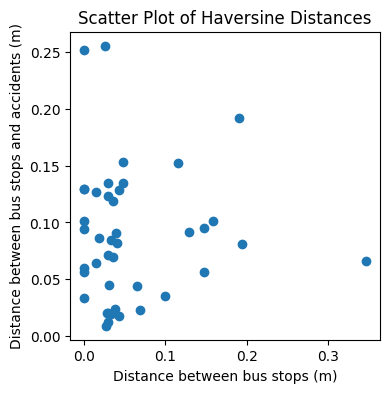

In [314]:
plt.rcParams['figure.figsize'] = [4, 4]
plt.scatter(bus_list, crash_list)
plt.xlabel("Distance between bus stops (m)")
plt.ylabel("Distance between bus stops and accidents (m)")
plt.title("Scatter Plot of Haversine Distances")
plt.show()

In [315]:
# Calculate Pearson's r
correlation_coefficient, _ = pearsonr(bus_list, crash_list)

print(f"Pearson correlation coefficient (r): {correlation_coefficient:.4f}")

Pearson correlation coefficient (r): 0.0097


The scatterplot shows now viual relatioship between the two distance measurements. As the Pearson value is close to 0 it also indicates no significant linear relationship between the variables .Correlation analysys through a scaterplot and calculation of Pearson Correlation Coefficient do not suggest any relationship between the distances between bus stops and the distances of accidents from bus stops. This suggests it is more likely that the accidents occur at random and distance of accidents from bus stops cannot be predicted based on distance between bus stops.

### DISCUSSION OF FINDINGS

The area of this use case is that of Central Melbourne, along William and Peel streets bus network. The exploratory section of this use case determined that there were 335 crashes in the 12-year period included in the data. Of these, seven were fatalities, 141 required hospitalisation and the remaining 201 caused little injury. Geomapping accident types revealed that all fatalities excepting one occurred close to bus stop locations.

The analysis section estimated the distances between bus stops and from accident locations to bus stop locations. Haversine distance was chosen for its ease of calculation from latitude and longitude data in the datasets as well as its accuracy. Most bus stops had 500m or less between them, while accidents occurred mostly within 1km of bus stops. The most dangerous bus stop is location 1268402, at the corner of King street and Collins street, with over 32 pedestrian accidents over the 12 year period.

The correlation section sought to find if the minimum distance between bus stops can be used to estimate the distance of accidents from bus stops. Hypothesis testing was inconclusive in finding a relationship between the distances. Correlation analysis did not show any strong linear or other relationships between the data. As no correlation was evident, the distance between bus stops cannot be used to predict the distance of accidents from bus stops.


### FUTURE DIRECTIONS FOR RESEARCH

 Adjusting the distance measure to occur along footpaths would be an investigation of interest. This use case uses Haversine for calculate the direct distance, but as there are buildings and obstacles across the city a direct path is not always available. The inclusion of city footpaths an measures of distance using these to assess bus stop distances would add an additional layer to this research. Extension of the area investigated in this use case is a further research direction. Comparison of areas with larger distances between bus stops as well as these relatively small distances between bus stops may allow for patterns to become clearer. Inclusion of pedestrian counts into research including bus stop and accident data would also be a consideration. This would allow visualisation of the effect of higher pedestrian numbers on accident location, as well as valuable insight into the relationship between pedestrian numbers and bus stop locations. 

### REFERENCES

<fn id="fn-1">[1]</fn> Transport Accident Commission (2024) [Pedestrian statistics](https://www.tac.vic.gov.au/road-safety/statistics/summaries/pedestrian-statistics) Victoria, Australia.

<fn id="fn-2">[2]</fn> Victoria Walks (2023) [Walking to Bus Stops](https://www.victoriawalks.org.au/bus_access/). VicHealth. Victoria, Australia.

<fn id="fn-3">[3]</fn> Victoria Road Safety Data Analysis (2020) [Putting the Connectivity in C-ITS](https://www.victoriawalks.org.au/bus_access/). University of Melbourne. Victoria, Australia.

<fn id="fn-4">[4]</fn> Geeks for Geeks (2022) [Haversine formula to find distance between two points on a sphere](https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/). Geeks for Geeks. Uttar Pradesh.

<fn id="fn-45">[5]</fn> GraphPad eBook (2022) [The Ultimate Guide to T Tests](https://www.graphpad.com/guides/the-ultimate-guide-to-t-tests). GraphPad, Dotmatics.

